# Description

To write pure code for creating the model of Dogs vs Cats

https://www.kaggle.com/c/dogs-vs-cats

# Review: easy steps to train a world-class image classifier

Original plans:

1. precompute=True
1. Use `lr_find()` to find highest learning rate where loss is still clearly improving
1. Train last layer from precomputed activations for 1-2 epochs
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use `lr_find()` again
1. Train full network with cycle_mult=2 until over-fitting


Edited by me:
1. Step 1
    1. Initialization
1. Step 2
    1. Use `lr_find()` to find highest learning rate where loss is still clearly improving
1. Step 3
    1. precompute=True
    1. Train last layer from precomputed activations for 1-2 epochs
1. Step 4: analyzing results
1. Step 5
    1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Step 6: analyzing results
1. Step 7
    1. Unfreeze all layers
    1. Set earlier layers to 3x-10x lower learning rate than next higher layer
    1. Use `lr_find()` again
    1. Train full network with cycle_mult=2 until over-fitting
1. Step 8: analyzing results
1. Step 9: TTA
    1. Use the TTA
1. Step 10: analyzing results

# Step 1: init

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
PATH = "data/dogscats/"
sz=224

In [5]:
torch.cuda.is_available()

True

In [6]:
torch.backends.cudnn.enabled

True

# Step 2: finding learning rate

In [11]:
# ITSMY:

arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))

In [12]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [13]:
lrf=learn.lr_find()

 79%|███████▉  | 284/360 [00:04<00:01, 68.52it/s, loss=0.192]


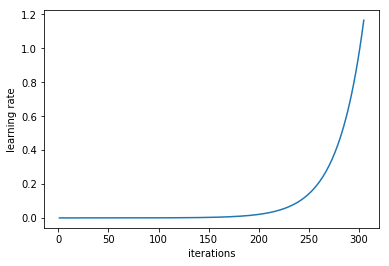

In [14]:
learn.sched.plot_lr()

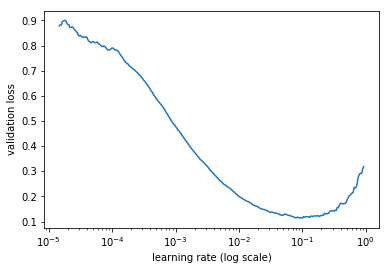

In [15]:
learn.sched.plot()

\# ITSMY:

We can see that the minimum of the valivation loss (~0.1) is equal to the 1e-1 of learning rate. As recommended in Lesson 2, we should choose a LR value one order of magnitude smaller. Hence, the LR must be 1e-2.

# Step 3: first training

In [16]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

epoch      trn_loss   val_loss   accuracy                     
    0      0.048217   0.030069   0.9865    
    1      0.046138   0.026082   0.9885                       



[array([0.02608]), 0.9885]

# Step 4: analyzing results

In [17]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(2000, 2)

In [18]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

In [19]:
# ITSMY:

# This is the label for a val data
y = data.val_y
y.shape

(2000,)

In [20]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[991   9]
 [ 14 986]]


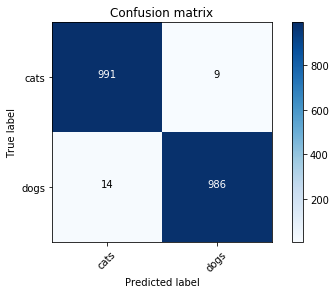

In [21]:
plot_confusion_matrix(cm, data.classes)

In [22]:
# ITSMY: calculate some rates from the confusion matrix

# Format of cm: cm[row, col]

print('Predicted dogs = {}'.format(cm[1, 1] + cm[0, 1]))
print('Predicted cats = {}'.format(cm[0, 0] + cm[1, 0]))
predicted_dogs = cm[1, 1] + cm[0, 1]
predicted_cats = cm[0, 0] + cm[1, 0]

print('Actual dogs = {}'.format(cm[0, 0] + cm[0, 1]))
print('Actual cats = {}'.format(cm[1, 0] + cm[1, 1]))
actual_dogs = cm[0, 0] + cm[0, 1]
actual_cats = cm[1, 0] + cm[1, 1]
total = actual_dogs + actual_cats

print('True dogs = {}'.format(cm[1, 1]))
print('True cats = {}'.format(cm[0, 0]))
true_dogs = cm[1, 1]
true_cats = cm[0, 0]

print('False dogs = {}'.format(cm[0, 1]))
print('False cats = {}'.format(cm[1, 0]))
false_dogs = cm[0, 1]
false_cats = cm[1, 0]

print('\n*** Rates ***\n')
accuracy = (true_dogs + true_cats) / total
print('Accuracy = %s' % accuracy)

misclassification_rate = (false_dogs + false_cats) / total
print('Misclassification rate = %s' % misclassification_rate)

true_dogs_rate = true_dogs / actual_dogs
print('True dogs rate = %s' % true_dogs_rate)

true_cats_rate = true_cats / actual_cats
print('True cats rate = %s' % true_cats_rate)

Predicted dogs = 995
Predicted cats = 1005
Actual dogs = 1000
Actual cats = 1000
True dogs = 986
True cats = 991
False dogs = 9
False cats = 14

*** Rates ***

Accuracy = 0.9885
Misclassification rate = 0.0115
True dogs rate = 0.986
True cats rate = 0.991


# Step 5: data augmentation

In [23]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [24]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [25]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [26]:
learn.precompute=False

In [27]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.06277    0.029466   0.99      
    1      0.047464   0.025175   0.9905                       
    2      0.04239    0.024525   0.991                        



[array([0.02452]), 0.991]

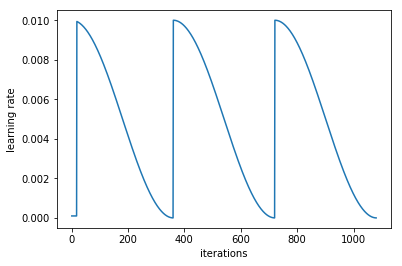

In [28]:
learn.sched.plot_lr()

# Step 6: analyzing results

In [29]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(2000, 2)

In [30]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

In [31]:
# ITSMY:

# This is the label for a val data
y = data.val_y
y.shape

(2000,)

In [32]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[993   7]
 [ 11 989]]


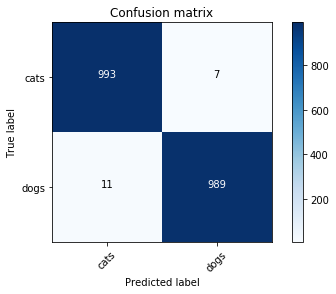

In [33]:
plot_confusion_matrix(cm, data.classes)

In [34]:
# ITSMY: calculate some rates from the confusion matrix

# Format of cm: cm[row, col]

print('Predicted dogs = {}'.format(cm[1, 1] + cm[0, 1]))
print('Predicted cats = {}'.format(cm[0, 0] + cm[1, 0]))
predicted_dogs = cm[1, 1] + cm[0, 1]
predicted_cats = cm[0, 0] + cm[1, 0]

print('Actual dogs = {}'.format(cm[0, 0] + cm[0, 1]))
print('Actual cats = {}'.format(cm[1, 0] + cm[1, 1]))
actual_dogs = cm[0, 0] + cm[0, 1]
actual_cats = cm[1, 0] + cm[1, 1]
total = actual_dogs + actual_cats

print('True dogs = {}'.format(cm[1, 1]))
print('True cats = {}'.format(cm[0, 0]))
true_dogs = cm[1, 1]
true_cats = cm[0, 0]

print('False dogs = {}'.format(cm[0, 1]))
print('False cats = {}'.format(cm[1, 0]))
false_dogs = cm[0, 1]
false_cats = cm[1, 0]

print('\n*** Rates ***\n')
accuracy = (true_dogs + true_cats) / total
print('Accuracy = %s' % accuracy)

misclassification_rate = (false_dogs + false_cats) / total
print('Misclassification rate = %s' % misclassification_rate)

true_dogs_rate = true_dogs / actual_dogs
print('True dogs rate = %s' % true_dogs_rate)

true_cats_rate = true_cats / actual_cats
print('True cats rate = %s' % true_cats_rate)

Predicted dogs = 996
Predicted cats = 1004
Actual dogs = 1000
Actual cats = 1000
True dogs = 989
True cats = 993
False dogs = 7
False cats = 11

*** Rates ***

Accuracy = 0.991
Misclassification rate = 0.009
True dogs rate = 0.989
True cats rate = 0.993


# Step 7: unfrezze all layers

In [35]:
learn.unfreeze()

In [36]:
lr=np.array([1e-4,1e-3,1e-2])

In [37]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                     
    0      0.043128   0.026869   0.99      
    1      0.036925   0.024405   0.99                         
    2      0.033234   0.023878   0.99                         
    3      0.026184   0.023404   0.9905                       
    4      0.023668   0.022382   0.991                        
    5      0.025952   0.022911   0.991                        
    6      0.021524   0.022294   0.9925                       



[array([0.02229]), 0.9925]

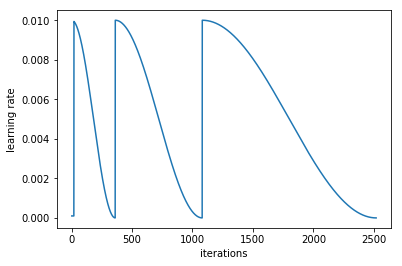

In [38]:
learn.sched.plot_lr()

# Step 8: analyzing results

In [39]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(2000, 2)

In [40]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

In [41]:
# ITSMY:

# This is the label for a val data
y = data.val_y
y.shape

(2000,)

In [42]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[993   7]
 [  8 992]]


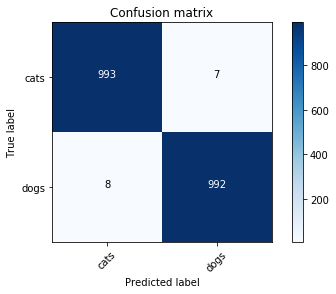

In [43]:
plot_confusion_matrix(cm, data.classes)

In [44]:
# ITSMY: calculate some rates from the confusion matrix

# Format of cm: cm[row, col]

print('Predicted dogs = {}'.format(cm[1, 1] + cm[0, 1]))
print('Predicted cats = {}'.format(cm[0, 0] + cm[1, 0]))
predicted_dogs = cm[1, 1] + cm[0, 1]
predicted_cats = cm[0, 0] + cm[1, 0]

print('Actual dogs = {}'.format(cm[0, 0] + cm[0, 1]))
print('Actual cats = {}'.format(cm[1, 0] + cm[1, 1]))
actual_dogs = cm[0, 0] + cm[0, 1]
actual_cats = cm[1, 0] + cm[1, 1]
total = actual_dogs + actual_cats

print('True dogs = {}'.format(cm[1, 1]))
print('True cats = {}'.format(cm[0, 0]))
true_dogs = cm[1, 1]
true_cats = cm[0, 0]

print('False dogs = {}'.format(cm[0, 1]))
print('False cats = {}'.format(cm[1, 0]))
false_dogs = cm[0, 1]
false_cats = cm[1, 0]

print('\n*** Rates ***\n')
accuracy = (true_dogs + true_cats) / total
print('Accuracy = %s' % accuracy)

misclassification_rate = (false_dogs + false_cats) / total
print('Misclassification rate = %s' % misclassification_rate)

true_dogs_rate = true_dogs / actual_dogs
print('True dogs rate = %s' % true_dogs_rate)

true_cats_rate = true_cats / actual_cats
print('True cats rate = %s' % true_cats_rate)

Predicted dogs = 999
Predicted cats = 1001
Actual dogs = 1000
Actual cats = 1000
True dogs = 992
True cats = 993
False dogs = 7
False cats = 8

*** Rates ***

Accuracy = 0.9925
Misclassification rate = 0.0075
True dogs rate = 0.992
True cats rate = 0.993


# Step 9: TTA

In [54]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

# Step 10: analyzing results

In [46]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(2000, 2)

In [47]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

In [48]:
# ITSMY:

# This is the label for a val data
y = data.val_y
y.shape

(2000,)

In [55]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[993   7]
 [  8 992]]


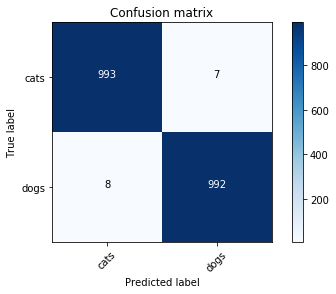

In [56]:
plot_confusion_matrix(cm, data.classes)

In [51]:
# ITSMY: calculate some rates from the confusion matrix

# Format of cm: cm[row, col]

print('Predicted dogs = {}'.format(cm[1, 1] + cm[0, 1]))
print('Predicted cats = {}'.format(cm[0, 0] + cm[1, 0]))
predicted_dogs = cm[1, 1] + cm[0, 1]
predicted_cats = cm[0, 0] + cm[1, 0]

print('Actual dogs = {}'.format(cm[0, 0] + cm[0, 1]))
print('Actual cats = {}'.format(cm[1, 0] + cm[1, 1]))
actual_dogs = cm[0, 0] + cm[0, 1]
actual_cats = cm[1, 0] + cm[1, 1]
total = actual_dogs + actual_cats

print('True dogs = {}'.format(cm[1, 1]))
print('True cats = {}'.format(cm[0, 0]))
true_dogs = cm[1, 1]
true_cats = cm[0, 0]

print('False dogs = {}'.format(cm[0, 1]))
print('False cats = {}'.format(cm[1, 0]))
false_dogs = cm[0, 1]
false_cats = cm[1, 0]

print('\n*** Rates ***\n')
accuracy = (true_dogs + true_cats) / total
print('Accuracy = %s' % accuracy)

misclassification_rate = (false_dogs + false_cats) / total
print('Misclassification rate = %s' % misclassification_rate)

true_dogs_rate = true_dogs / actual_dogs
print('True dogs rate = %s' % true_dogs_rate)

true_cats_rate = true_cats / actual_cats
print('True cats rate = %s' % true_cats_rate)

Predicted dogs = 999
Predicted cats = 1001
Actual dogs = 1000
Actual cats = 1000
True dogs = 992
True cats = 993
False dogs = 7
False cats = 8

*** Rates ***

Accuracy = 0.9925
Misclassification rate = 0.0075
True dogs rate = 0.992
True cats rate = 0.993


# Step 11: save the model

In [52]:
learn.save('v001_finished')

In [53]:
learn.load('v001_finished')